In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import imageio

為什麼要用 np.prod(img_shape)？
1.   匹配圖像維度：

*   生成器的目的是產生與真實數據（圖片）形狀相匹配的輸出。
*   例如，如果目標是生成 28x28 像素的灰階圖像，則 img_shape 可能是 (1, 28, 28)
*   因此 np.prod(img_shape) 會是 12828 = 784
*   生成器的最後一個線性層需要有 784 個輸出神經元，對應於圖像的每個像素點。
2.   圖像重塑：

*   在神經網絡中，輸出通常是一維的，而生成的圖像需要是多維的（如上述的 channels, height, width）
*   使用 np.prod(img_shape) 確保了輸出層的維度正好足以在之後的操作中被重新塑形為目標圖像的維度

3.   網絡結構的一致性：

*   確保生成器的輸出層與所需的圖像維度完全一致是重要的
*   這樣可以無縫地將網絡的輸出轉換成可視化的圖像，無需進行額外的處理或轉換

4.   簡化模型設計：

*   通過使用 np.prod(img_shape) 來設定輸出層的大小，開發者可以靈活地調整目標圖像的大小或深度（例如變更顏色通道數），而不必重新計算輸出層的大小
*   使用 np.prod(img_shape) 是為了讓生成器能夠直接生成具有所需形狀的圖像資料，這是實現圖像生成任務中的一個關鍵步驟

In [ ]:
# 定義生成器
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            # latent_dim: 潛在空間的維度，這是生成器的輸入。
            # 這個潛在空間(latent_dim)通常由隨機噪聲向量構成
            # 這些噪聲向量會被生成器轉化為可識別的數據，如圖像。
            nn.Linear(latent_dim, 128),
            # 第一層將潛在空間的維度映射到一個更高的維度空間
            # 將高維噪聲資料轉換為有用特徵的第一步

            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(img_shape))),
            # 使用 np.prod(img_shape) 是為了確定最終輸出層的神經元數量，這個數量應該與目標圖片的總像素數相匹配
            # img_shape: 生成圖片的形狀(channels, height, width)
            # np.prod(img_shape)是計算這三個維度的乘積，從而得到總的像素數或者說是總的資料點數
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img



在生成對抗網絡（GAN）的生成器中，forward 方法是負責接收潛在空間的向量 z，並透過神經網絡將其轉換成最終的圖像輸出。以下是 forward 方法的詳細步驟和目的解釋：

1.   輸入潛在向量 z

*   z 是一個來自潛在空間的向量，通常是隨機生成的，其維度由 latent_dim 決定
*   這些向量是生成過程的基礎，包含足夠的隨機性來驅動生成器創造多樣化的輸出
2.   通過神經網絡模型

*   img = self.model(z)：這一行代碼將潛在向量 z 作為輸入，通過生成器中定義的一系列神經網絡層（如線性層和作用函數等）
*   這些層逐步將維度從潛在空間轉換到最終的圖像維度的平展（flattened）形態

3.   調整輸出維度以形成圖像

*   img = img.view(img.size(0), *self.img_shape)：這行代碼將前一步產生的扁平化圖像向量重新形狀（reshape）為具有指定通道數和尺寸的圖像
*   img.size(0) 表示批量大小，即一次處理多少圖像的數量，而 *self.img_shape 則是生成器設定的目標圖像形狀，如 (channels, height, width)
4.   返回最終圖像：

*   return img：這一行將調整後的圖像數據作為輸出返回
*   這些圖像已經從一維向量轉換為多維數據格式，可以直接用於視覺化或進一步的處理
##### 目的
*   生成逼真的圖像：forward 方法的核心目標是將隨機噪聲向量 z 轉換為逼真的圖像，這些圖像應該盡可能地模仿訓練數據集中的真實圖像
*   支持批量處理：通過處理整個批量的圖像，GAN 能夠更有效地學習和優化，這在實際應用中尤為重要
*   *   *   
總之，forward 方法是生成器功能的實現核心，負責將潛在空間的抽象向量轉化為具體的圖像輸出，這是實現生成器學習目標的關鍵過程。

In [ ]:
# 定義判別器
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
# 超參數設置
latent_dim = 100
img_shape = (1, 28, 28)  # MNIST 圖像大小
lr = 0.0002
batch_size = 64
num_epochs = 100
sample_interval = 400  # 每隔多少個批次生成一次圖像

In [ ]:
# 加載 MNIST 數據集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14670789.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497464.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4511224.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3076138.99it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 創建生成器和判別器
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)



In [ ]:
# 定義優化器
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
# 定義損失函數
criterion = nn.BCELoss()
# 使用二元交叉熵損失（BCELoss）
# 這是訓練 GANs 中常用的損失函數，用於評估判別器的預測與真實標籤之間的差異

In [ ]:
# 用於保存生成圖像的列表
img_list = []

# 創建列表來存儲損失值
d_losses = []
g_losses = []




*   (imgs, _) 意味著從 train_loader 中提取每批的圖像 imgs 而忽略相應的標籤
*   _這種做法很常見，尤其是在處理那些標籤對訓練過程不重要的機器學習任務時




In [ ]:
# 訓練循環
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
      # train_loader 是從 PyTorch 的 DataLoader 返回的一個迭代器，它每次迭代提供一批資料
      # imgs - 這是包含一批圖像數據的Tensor。這些圖像是訓練過程中將被用來訓練生成器和判別器的資料
      # 標籤 - 這通常是與每個圖像對應的標籤資料
      # 對於 MNIST 來說，這些標籤是 0 到 9 的數字，代表圖像中手寫數字的類別
      # 在訓練生成對抗網絡時，只需要圖像資料而不需要這些標籤
      # 因此可以使用 _ 來接收這部分不需要使用的標籤數據

        # 訓練判別器
        real_imgs = imgs
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)

        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs)

        d_loss_real = criterion(real_validity, torch.ones_like(real_validity))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity))
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # 訓練生成器
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        g_loss = criterion(fake_validity, torch.ones_like(fake_validity))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # 訓練過程中定期生成一批圖像
        batches_done = epoch * len(train_loader) + i
        # batches_done 用來計算在整個訓練過程中，已經處理過的批次（batch）數量
        # 這個計算可幫助追蹤訓練進度，並且常被用來在特定的訓練階段執行一些操作（如保存模型狀態、生成圖像等）
        # i 從 0 開始計數，到 len(train_loader)-1 結束
        # epoch * len(train_loader)：這部分計算到當前週期開始之前，已經處理過的batch總數
        # 例如，如果每個週期有 100 個batch，那麼在第 3 個週期開始時，已經處理了 3 * 100 = 300 個batch
        # + i：加上當前週期中已經完成的batch數，給出了從訓練開始到當前為止總共處理的batch數

        # 這樣的計算方式讓你可以精確地知道在整個訓練過程中已經完成了多少批次
        # 這對於設定檢查點（如定期保存模型）、進行評估或生成顯示圖像等操作非常有用
        # 用來決定何時生成和展示一批生成的圖像（每當 batches_done % sample_interval == 0 時），
        # 這樣做可以讓你看到生成器在訓練過程中的進展，而不需要等到訓練結束
        # 這是一種監控和調整生成器表現的有效方式，幫助我們理解模型在學習過程中的行為

        if batches_done % sample_interval == 0:
          #這行檢查當前處理的batch數 batches_done 是否是 sample_interval 的倍數
          # 如果是，就進行圖像的生成和展示
          # 這樣設定可以定期檢查生成器的輸出，而不需要每個batch都進行，從而節省計算資源並集中展示有意義的進展
            # 生成一批圖像並顯示
            z = torch.randn(25, latent_dim) # 生成一個形狀為 [25, latent_dim] 的Tensor
            gen_imgs = generator(z) # 產生 25 張新的圖像(25個潛在空間的隨機向量)
            gen_imgs = gen_imgs.view(25, 1, 28, 28)
            img_list.append(gen_imgs)

            plt.figure(figsize=(5, 5))
            for i in range(25):
                plt.subplot(5, 5, i+1) # 在 5x5 的網格中定位到第 i+1 的位置
                plt.imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
                #用於顯示圖像，其中 cmap='gray' 指定使用灰度色彩映射
                # detach() 方法用於將張量從當前計算圖中分離出來
                # 當Tensor參與到梯度計算中時，它會保持與創建它的計算圖的連接
                # detach() 是為了防止對這批圖像進行額外的梯度計算
                # 這通常在進行模型評估或只是需要數據本身而不是其梯度時非常有用
                # 影響: 使得生成的圖像數據在內存中變得更輕量，因為它不再需要存儲用於梯度計算的額外訊息
                #####################
                # numpy(): 將 PyTorch Tensor 轉換為 NumPy Array
                #####################
                # squeeze(): 用於去除資料維度中的單一維度（即維度大小為1的維度）
                # gen_imgs[i] 可能有一個形狀為 [1, 28, 28]（即，一個單一的28x28圖像，其中的1表示色彩通道是灰階）
                # 使用 squeeze() 後，如果有任何單維度，它們會被移除，使圖像的形狀變為 [28, 28]
                # 這是 Matplotlib 所需的格式，以便正確顯示灰階圖像

                plt.axis('off') # 關閉坐標軸的顯示，使圖像更為清晰
            plt.tight_layout() # 確保子圖之間的布局合適，沒有重疊或不必要的空白
            plt.show()

        # 記錄每個 epoch 的損失值
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 假設每個 epoch 有 n_batches 個 batches
n_batches = len(train_loader)

# 計算每個 epoch 的平均損失
average_d_losses = [sum(d_losses[i * n_batches:(i + 1) * n_batches]) / n_batches for i in range(epochs)]
average_g_losses = [sum(g_losses[i * n_batches:(i + 1) * n_batches]) / n_batches for i in range(epochs)]

# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(average_d_losses, label="D_loss")
plt.plot(average_g_losses, label="G_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

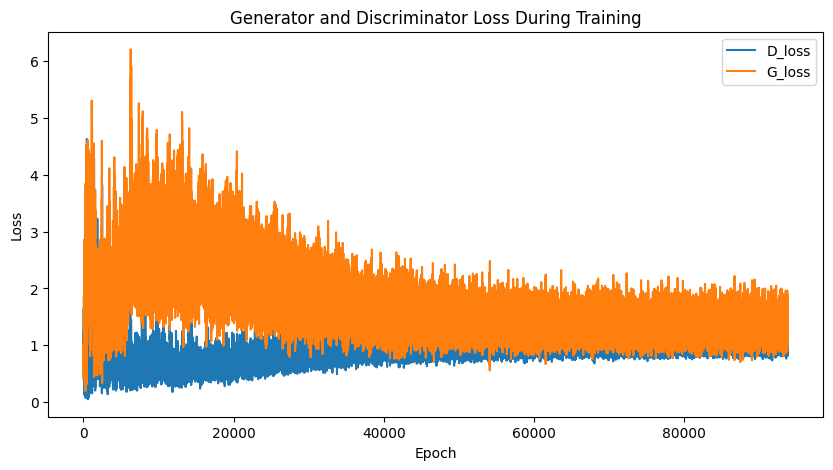

In [ ]:
# 繪製損失曲線
# 迭代次數（iterations），每個迭代處理一個批次（batch），而非整個數據集
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_losses, label="D_loss")
plt.plot(g_losses, label="G_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!pip install imageio

In [ ]:
# 使用 imageio 創建動圖
with imageio.get_writer('gan_animation.gif', mode='I') as writer:
    for imgs in img_list:
        grid = np.zeros((5*28, 5*28))
        for i in range(5):
            for j in range(5):
                grid[i*28:(i+1)*28, j*28:(j+1)*28] = imgs[i*5+j].detach().cpu().numpy().squeeze()
        writer.append_data((grid * 255).astype(np.uint8))